In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/vituri/Documentos/GitHub/blog/posts/symbolic regression"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


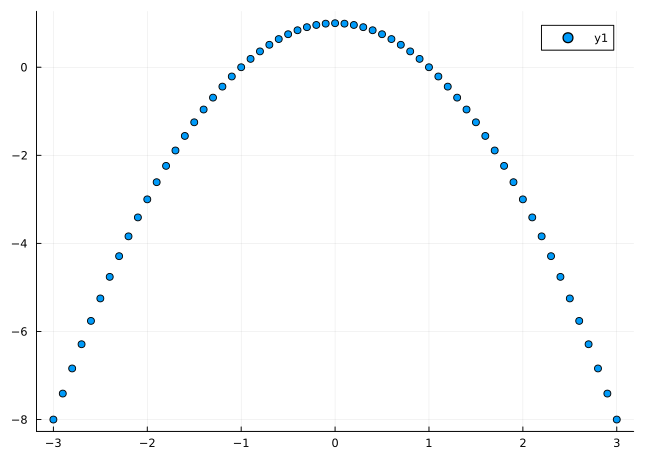

In [2]:
using SymbolicRegression, MLJ, SymbolicUtils
using Plots

x = [-3:0.1:3;]
y = @. - x^2 + 1;

scatter(x, y)

In [3]:
model = SRRegressor(
    binary_operators=[+, -, *],    
    niterations=50
);

In [4]:
#| output: false
X = reshape(x, (length(x), 1))

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<-1:-43, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           1.270e+01  3.604e+01  y = 0.13948                                   5           1.153e+01  2.420e-02  y = ((x₁ - x₁) - 0.13948)                     7           1.000e+00  1.222e+00  y = (x₁ - ((x₁ * x₁) + x₁))                   9           1.020e-01  1.142e+00  y = ((x₁ - ((x₁ * x₁) + x₁)) + 1.3193)        11          4.145e-03  1.601e+00  y = ((x₁ - (((x₁ * x₁) + x₁) + 0.25495)) + 1.3193)                                    

2.1%┣█                                            ┫ 16/750 [00:00<00:15, 47it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.939e+00  3.604e+01  y = -2.6071                                   3           7.684e+00  1.631e-02  y = (-0.74758 - 1.4017)                       5           5.225e-04  4.798e+00  y = (0.97714 - (x₁ * x₁))                     7           1.965e-27  1.802e+01  y = (((x₁ * x₁) * -1) - -1)                   ---------------------------------------------------------------------------------------------------


3.1%┣█▍                                           ┫ 23/750 [00:00<00:13, 57it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
4.1%┣█▉                                           ┫ 31/750 [00:00<00:11, 67it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.8%         Press 'q' and then <

5.1%┣██▎                                          ┫ 38/750 [00:01<00:10, 71it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


5.9%┣██▋                                          ┫ 44/750 [00:01<00:10, 74it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
6.7%┣███                                          ┫ 50/750 [00:01<00:09, 75it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <

7.5%┣███▍                                         ┫ 56/750 [00:01<00:09, 75it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


8.3%┣███▊                                         ┫ 62/750 [00:01<00:09, 76it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
9.1%┣████                                         ┫ 68/750 [00:01<00:09, 78it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <

10.0%┣████▍                                       ┫ 75/750 [00:01<00:08, 80it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
11.2%┣█████                                       ┫ 84/750 [00:01<00:08, 84it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <

12.1%┣█████▍                                      ┫ 91/750 [00:01<00:08, 86it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


13.1%┣█████▊                                      ┫ 98/750 [00:01<00:07, 87it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
13.9%┣██████                                     ┫ 104/750 [00:01<00:07, 87it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.5%        Press 'q' and then <

14.7%┣██████▎                                    ┫ 110/750 [00:01<00:07, 88it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
15.5%┣██████▋                                    ┫ 116/750 [00:01<00:07, 88it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <

16.1%┣███████                                    ┫ 121/750 [00:01<00:07, 88it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


17.1%┣███████▍                                   ┫ 128/750 [00:01<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
17.9%┣███████▊                                   ┫ 134/750 [00:01<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <

18.7%┣████████                                   ┫ 140/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


19.5%┣████████▍                                  ┫ 146/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
20.4%┣████████▊                                  ┫ 153/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <

21.2%┣█████████▏                                 ┫ 159/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


22.1%┣█████████▌                                 ┫ 166/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
22.8%┣█████████▉                                 ┫ 171/750 [00:02<00:07, 89it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.6%        Press 'q' and then <

23.9%┣██████████▎                                ┫ 179/750 [00:02<00:06, 90it/s]Expressions evaluated per second: 1.06e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
24.8%┣██████████▋                                ┫ 186/750 [00:02<00:06, 90it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <

25.7%┣███████████                                ┫ 193/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


26.8%┣███████████▌                               ┫ 201/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
27.6%┣███████████▉                               ┫ 207/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

28.4%┣████████████▏                              ┫ 213/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


29.3%┣████████████▋                              ┫ 220/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
30.3%┣█████████████                              ┫ 227/750 [00:02<00:06, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

31.2%┣█████████████▍                             ┫ 234/750 [00:03<00:06, 93it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
32.0%┣█████████████▊                             ┫ 240/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

32.8%┣██████████████                             ┫ 246/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


33.6%┣██████████████▌                            ┫ 252/750 [00:03<00:05, 93it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
34.5%┣██████████████▉                            ┫ 259/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

35.3%┣███████████████▏                           ┫ 265/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
36.1%┣███████████████▌                           ┫ 271/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <

37.1%┣████████████████                           ┫ 278/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


37.9%┣████████████████▎                          ┫ 284/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
38.7%┣████████████████▋                          ┫ 290/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.6%        Press 'q' and then <

39.5%┣█████████████████                          ┫ 296/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


40.3%┣█████████████████▎                         ┫ 302/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
41.1%┣█████████████████▋                         ┫ 308/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <

42.0%┣██████████████████                         ┫ 315/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
42.8%┣██████████████████▍                        ┫ 321/750 [00:03<00:05, 94it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <

43.5%┣██████████████████▊                        ┫ 326/750 [00:04<00:05, 93it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
44.1%┣███████████████████                        ┫ 331/750 [00:04<00:05, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <

44.8%┣███████████████████▎                       ┫ 336/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
45.6%┣███████████████████▋                       ┫ 342/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <

46.3%┣████████████████████                       ┫ 347/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


46.9%┣████████████████████▏                      ┫ 352/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
47.9%┣████████████████████▋                      ┫ 359/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <

48.5%┣████████████████████▉                      ┫ 364/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


49.3%┣█████████████████████▏                     ┫ 370/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.09e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
50.1%┣█████████████████████▋                     ┫ 376/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

50.8%┣█████████████████████▉                     ┫ 381/750 [00:04<00:04, 91it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
51.7%┣██████████████████████▎                    ┫ 388/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

52.5%┣██████████████████████▋                    ┫ 394/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


53.3%┣███████████████████████                    ┫ 400/750 [00:04<00:04, 91it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
54.1%┣███████████████████████▎                   ┫ 406/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.6%        Press 'q' and then <

54.9%┣███████████████████████▋                   ┫ 412/750 [00:04<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


55.7%┣████████████████████████                   ┫ 418/750 [00:05<00:04, 91it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
56.7%┣████████████████████████▍                  ┫ 425/750 [00:05<00:04, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

57.5%┣████████████████████████▊                  ┫ 431/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


58.4%┣█████████████████████████▏                 ┫ 438/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
59.3%┣█████████████████████████▌                 ┫ 445/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

60.0%┣█████████████████████████▉                 ┫ 450/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


60.9%┣██████████████████████████▏                ┫ 457/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
61.9%┣██████████████████████████▋                ┫ 464/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

62.5%┣███████████████████████████                ┫ 469/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


63.3%┣███████████████████████████▎               ┫ 475/750 [00:05<00:03, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
64.3%┣███████████████████████████▋               ┫ 482/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

65.1%┣████████████████████████████               ┫ 488/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
65.7%┣████████████████████████████▎              ┫ 493/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

66.7%┣████████████████████████████▊              ┫ 500/750 [00:05<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


67.6%┣█████████████████████████████              ┫ 507/750 [00:06<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
68.4%┣█████████████████████████████▍             ┫ 513/750 [00:06<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

69.2%┣█████████████████████████████▊             ┫ 519/750 [00:06<00:03, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
69.9%┣██████████████████████████████             ┫ 524/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

70.8%┣██████████████████████████████▍            ┫ 531/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


71.6%┣██████████████████████████████▉            ┫ 537/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
72.4%┣███████████████████████████████▏           ┫ 543/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <

73.3%┣███████████████████████████████▌           ┫ 550/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


74.1%┣███████████████████████████████▉           ┫ 556/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
75.1%┣████████████████████████████████▎          ┫ 563/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.5%        Press 'q' and then <

75.7%┣████████████████████████████████▋          ┫ 568/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


76.4%┣████████████████████████████████▉          ┫ 573/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
77.3%┣█████████████████████████████████▎         ┫ 580/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

78.0%┣█████████████████████████████████▌         ┫ 585/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
78.9%┣██████████████████████████████████         ┫ 592/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

79.6%┣██████████████████████████████████▎        ┫ 597/750 [00:06<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


80.4%┣██████████████████████████████████▋        ┫ 603/750 [00:07<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
81.3%┣███████████████████████████████████        ┫ 610/750 [00:07<00:02, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

82.0%┣███████████████████████████████████▎       ┫ 615/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


82.8%┣███████████████████████████████████▋       ┫ 621/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
83.9%┣████████████████████████████████████       ┫ 629/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

84.7%┣████████████████████████████████████▍      ┫ 635/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


85.3%┣████████████████████████████████████▊      ┫ 640/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
86.1%┣█████████████████████████████████████      ┫ 646/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.04e+05. Head worker occupation: 3.4%        Press 'q' and then <

86.8%┣█████████████████████████████████████▎     ┫ 651/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
87.6%┣█████████████████████████████████████▊     ┫ 657/750 [00:07<00:01, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <

88.3%┣██████████████████████████████████████     ┫ 662/750 [00:07<00:01, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


88.9%┣██████████████████████████████████████▎    ┫ 667/750 [00:07<00:01, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
89.6%┣██████████████████████████████████████▌    ┫ 672/750 [00:07<00:01, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <

90.7%┣███████████████████████████████████████    ┫ 680/750 [00:07<00:01, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


91.7%┣███████████████████████████████████████▌   ┫ 688/750 [00:07<00:01, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
92.5%┣███████████████████████████████████████▉   ┫ 694/750 [00:08<00:01, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <

93.5%┣████████████████████████████████████████▏  ┫ 701/750 [00:08<00:01, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
94.3%┣████████████████████████████████████████▌  ┫ 707/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <

95.1%┣████████████████████████████████████████▉  ┫ 713/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


95.9%┣█████████████████████████████████████████▎ ┫ 719/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


96.7%┣█████████████████████████████████████████▋ ┫ 725/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
97.5%┣██████████████████████████████████████████ ┫ 731/750 [00:08<00:00, 92it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.3%        Press 'q' and then <

98.1%┣██████████████████████████████████████████▏┫ 736/750 [00:08<00:00, 91it/s]Expressions evaluated per second: 1.03e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------
98.9%┣██████████████████████████████████████████▌┫ 742/750 [00:08<00:00, 91it/s]Expressions evaluated per second: 1.02e+05. Head worker occupation: 3.3%        Press 'q' and then <

99.7%┣██████████████████████████████████████████▉┫ 748/750 [00:08<00:00, 91it/s]Expressions evaluated per second: 1.02e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           7.682e+00  3.604e+01  y = -2.1                                      5           0.000e+00  9.011e+00  y = (1 - (x₁ * x₁))                           ---------------------------------------------------------------------------------------------------


trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @661 ⏎ AbstractMatrix{Continuous}
    2:	Source @921 ⏎ AbstractVector{Continuous}


In [5]:
r = report(mach);

r

(best_idx = 2,
 equations = DynamicExpressions.EquationModule.Node{Float64}[-2.1000000000160663, (1.0 - (x₁ * x₁))],
 equation_strings = ["-2.1000000000160663", "(1.0 - (x₁ * x₁))"],
 losses = [7.681799999999998, 0.0],
 complexities = [1, 5],
 scores = [36.04365338911715, 9.010913347279288],)

In [6]:
r.losses

2-element Vector{Float64}:
 7.681799999999998
 0.0

In [7]:
r.equations

2-element Vector{DynamicExpressions.EquationModule.Node{Float64}}:
 -2.1000000000160663
 (1.0 - (x₁ * x₁))

In [8]:
node_to_symbolic(r.equations[r.best_idx], model)

1.0 - (x1 * x1)

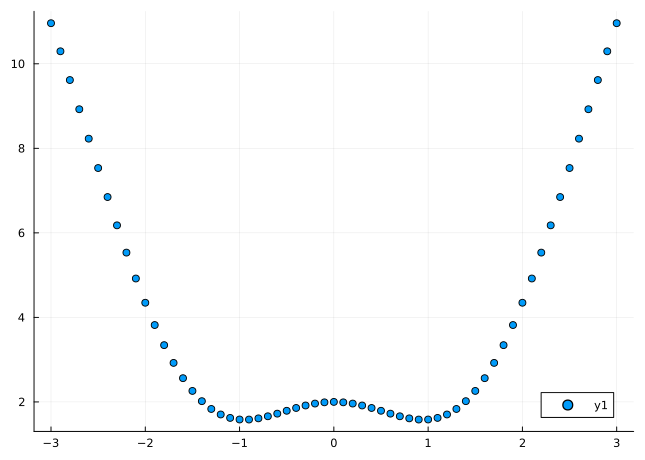

In [9]:
y = @. x^2 + 2cos(x)^2 

scatter(x, y)

In [10]:
#| output: false

model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=50
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                             ┫ 0/750 [00:00<00:-10, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.913e-01  5.325e-01  y = ((x₁ * x₁) + 1.0539)                      6           4.844e-01  1.426e-02  y = ((x₁ * x₁) + cos(-0.27609))               7           4.843e-01  1.242e-04  y = (((x₁ * x₁) + 0.84094) + 0.13093)         9           4.843e-01  3.285e-06  y = ((

1.7%┣▉                                            ┫ 13/750 [00:00<00:09, 80it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.764e-01  8.222e-03  y = (((x₁ * x₁) - -0.86312) * 1.0182)         8           4.114e-01  1.468e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.596e-01  1.345e-01  y = ((

2.5%┣█▏                                           ┫ 19/750 [00:00<00:09, 84it/s]Expressions evaluated per second: [.....]. Head worker occupation: 3.5%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.764e-01  8.222e-03  y = (((x₁ * x₁) - -0.86312) * 1.0182)         8           4.114e-01  1.468e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.596e-01  1.345e-01  y = ((

5.1%┣██▎                                         ┫ 38/750 [00:00<00:06, 110it/s]Expressions evaluated per second: [.....]. Head worker occupation: 6.8%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.764e-01  8.222e-03  y = (((x₁ * x₁) - -0.86312) * 1.0182)         8           4.114e-01  1.468e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.329e-01  2.117e-01  y = ((

6.9%┣███                                         ┫ 52/750 [00:00<00:06, 113it/s]Expressions evaluated per second: [.....]. Head worker occupation: 6.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) - -0.80722) * 1.0417)         8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

8.7%┣███▉                                        ┫ 65/750 [00:01<00:06, 113it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.6%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) - -0.80722) * 1.0417)         8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

9.6%┣████▎                                       ┫ 72/750 [00:01<00:06, 113it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.5%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

11.5%┣█████                                      ┫ 86/750 [00:01<00:06, 114it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

13.1%┣█████▋                                     ┫ 98/750 [00:01<00:06, 109it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

14.0%┣█████▉                                    ┫ 105/750 [00:01<00:06, 110it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

14.9%┣██████▍                                    ┫ 112/750 [00:01<00:07, 86it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.325e-01  2.130e-01  y = ((

17.1%┣███████▍                                   ┫ 128/750 [00:02<00:08, 76it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.083e-01  2.884e-01  y = ((

19.2%┣████████▎                                  ┫ 144/750 [00:02<00:08, 80it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.083e-01  2.884e-01  y = ((

20.5%┣████████▉                                  ┫ 154/750 [00:02<00:07, 83it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.083e-01  2.884e-01  y = ((

22.9%┣█████████▉                                 ┫ 172/750 [00:02<00:07, 87it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.5%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           3.083e-01  2.884e-01  y = ((

25.5%┣███████████                                ┫ 191/750 [00:02<00:06, 91it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           2.871e-01  3.597e-01  y = ((

26.8%┣███████████▌                               ┫ 201/750 [00:02<00:06, 93it/s]Expressions evaluated per second: 1.41e+05. Head worker occupation: 3.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = ((x₁ * (x₁ * 1.0417)) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           2.871e-01  3.597e-01  y = ((

29.2%┣████████████▋                              ┫ 219/750 [00:02<00:06, 96it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           4.114e-01  1.353e-01  y = (cos(cos(cos(x₁))) + (x₁ * x₁))           9           2.871e-01  3.597e-01  y = ((

31.5%┣█████████████▌                             ┫ 236/750 [00:02<00:05, 98it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

32.7%┣██████████████                             ┫ 245/750 [00:02<00:05, 99it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

35.1%┣██████████████▊                           ┫ 263/750 [00:03<00:05, 101it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

36.0%┣███████████████▏                          ┫ 270/750 [00:03<00:05, 101it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 3.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

38.3%┣████████████████                          ┫ 287/750 [00:03<00:05, 103it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

39.3%┣████████████████▌                         ┫ 295/750 [00:03<00:04, 103it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.699e-01  2.415e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.2388)          9           2.871e-01  2.536e-01  y = ((

41.5%┣█████████████████▍                        ┫ 311/750 [00:03<00:04, 104it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

43.7%┣██████████████████▍                       ┫ 328/750 [00:03<00:04, 106it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

45.9%┣███████████████████▎                      ┫ 344/750 [00:03<00:04, 106it/s]Expressions evaluated per second: 1.60e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

47.1%┣███████████████████▊                      ┫ 353/750 [00:03<00:04, 107it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

49.2%┣████████████████████▋                     ┫ 369/750 [00:03<00:04, 108it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

51.2%┣█████████████████████▌                    ┫ 384/750 [00:04<00:03, 109it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

53.5%┣██████████████████████▌                   ┫ 401/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

54.5%┣███████████████████████                   ┫ 409/750 [00:04<00:03, 110it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

56.7%┣███████████████████████▉                  ┫ 425/750 [00:04<00:03, 111it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

58.7%┣████████████████████████▋                 ┫ 440/750 [00:04<00:03, 111it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

60.5%┣█████████████████████████▍                ┫ 454/750 [00:04<00:03, 112it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

61.5%┣█████████████████████████▉                ┫ 461/750 [00:04<00:03, 112it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

63.5%┣██████████████████████████▋               ┫ 476/750 [00:04<00:02, 112it/s]Expressions evaluated per second: 1.80e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

65.6%┣███████████████████████████▌              ┫ 492/750 [00:04<00:02, 113it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

67.7%┣████████████████████████████▌             ┫ 508/750 [00:04<00:02, 113it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

68.8%┣█████████████████████████████             ┫ 516/750 [00:05<00:02, 114it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

70.9%┣█████████████████████████████▉            ┫ 532/750 [00:05<00:02, 114it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           3.343e-01  3.429e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.4026)          9           2.871e-01  1.522e-01  y = ((

73.3%┣██████████████████████████████▉           ┫ 550/750 [00:05<00:02, 115it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

74.3%┣███████████████████████████████▏          ┫ 557/750 [00:05<00:02, 115it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

76.3%┣████████████████████████████████          ┫ 572/750 [00:05<00:02, 115it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

78.5%┣█████████████████████████████████         ┫ 589/750 [00:05<00:01, 116it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

79.6%┣█████████████████████████████████▍        ┫ 597/750 [00:05<00:01, 116it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

81.5%┣██████████████████████████████████▏       ┫ 611/750 [00:05<00:01, 116it/s]Expressions evaluated per second: 1.89e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

83.5%┣███████████████████████████████████       ┫ 626/750 [00:05<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

84.4%┣███████████████████████████████████▌      ┫ 633/750 [00:05<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

86.5%┣████████████████████████████████████▍     ┫ 649/750 [00:06<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

88.7%┣█████████████████████████████████████▎    ┫ 665/750 [00:06<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

89.6%┣█████████████████████████████████████▋    ┫ 672/750 [00:06<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

91.3%┣██████████████████████████████████████▍   ┫ 685/750 [00:06<00:01, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

93.2%┣███████████████████████████████████████▏  ┫ 699/750 [00:06<00:00, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

95.1%┣████████████████████████████████████████  ┫ 713/750 [00:06<00:00, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

96.1%┣████████████████████████████████████████▍ ┫ 721/750 [00:06<00:00, 116it/s]Expressions evaluated per second: 1.94e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

98.3%┣█████████████████████████████████████████▎┫ 737/750 [00:06<00:00, 116it/s]Expressions evaluated per second: 1.95e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           8.807e+00  3.604e+01  y = 4.0701                                    3           1.425e+00  9.105e-01  y = (x₁ * x₁)                                 5           4.843e-01  5.397e-01  y = ((x₁ * x₁) + 0.97009)                     7           4.710e-01  1.397e-02  y = (((x₁ * x₁) * 1.0417) + 0.84087)          8           2.558e-01  6.103e-01  y = (((x₁ * x₁) + cos(x₁)) * 1.3284)          10          5.353e-21  1.802e+01  y = ((

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @559 ⏎ AbstractMatrix{Continuous}
    2:	Source @811 ⏎ AbstractVector{Continuous}


In [11]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

cos(x1 + x1) + (cos(x1 - x1) + (x1 * x1))

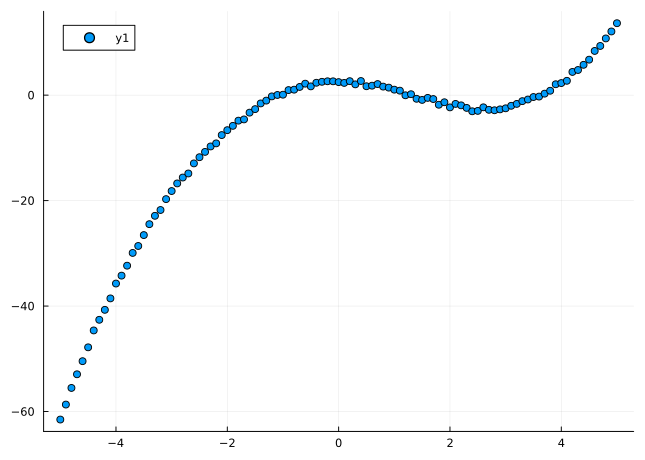

In [12]:
x = [-5:0.1:5;]
X = reshape(x, (length(x), 1))
errors = rand(length(x))
y = @. 0.3*x^3 - x^2 + 2cos(x) + errors

scatter(x, y)

In [13]:
#| output: false
model = SRRegressor(
    binary_operators = [+, -, *],    
    unary_operators = [cos],
    niterations=60
);

mach = machine(model, X, y)
fit!(mach)

[ Info: Training machine(SRRegressor(binary_operators = Function[+, -, *], …), …).
┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


0.0%┣                                              ┫ 0/900 [00:00<00:-2, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           3.548e+02  3.604e+01  y = 0.14609                                   3           2.726e+02  1.318e-01  y = (x₁ * 1.1716)                             5           2.698e+02  5.071e-03  y = (x₁ - cos(cos(x₁)))                       6           2.632e+02  2.485e-02  y = ((cos(-1.2058) + 0.97994) * x₁)           7           1.576e+02  5.131e-01  y = (x₁ - ((0.7242 * x₁) * x₁))               12          7.225e+01  1.559e-01  y = (x

1.7%┣▊                                           ┫ 15/900 [00:00<00:08, 117it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.916e+02  1.946e-01  y = (x₁ * 3.1189)                             5           7.518e+01  4.678e-01  y = (x₁ * (2.4473 - x₁))                      7           3.612e+01  3.665e-01  y = (((3.5909 - x₁) * x₁) + x₁)               9           3.612e+01  0.000e+00  y = ((((2.5909 - x₁) * x₁) + x₁) + x₁)        10          3.489e+01  3.446e-02  y = ((

3.4%┣█▌                                          ┫ 31/900 [00:00<00:07, 122it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.817e+02  2.212e-01  y = (3.5909 * x₁)                             5           4.256e+01  7.257e-01  y = (x₁ * (3.7203 - x₁))                      7           3.612e+01  8.207e-02  y = ((x₁ * (3.5909 - x₁)) + x₁)               8           2.935e+01  2.076e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          12          2.364e+01  5.404e-02  y = (x

4.2%┣█▉                                          ┫ 38/900 [00:00<00:07, 122it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.733e+02  2.449e-01  y = (x₁ * 4.7038)                             5           3.612e+01  7.841e-01  y = (x₁ * (4.5909 - x₁))                      7           3.612e+01  0.000e+00  y = ((x₁ * (3.5909 - x₁)) + x₁)               8           2.935e+01  2.076e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          12          2.364e+01  5.404e-02  y = (x

5.7%┣██▌                                         ┫ 51/900 [00:00<00:07, 115it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.4%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.732e+02  2.452e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.611e+01  1.640e-04  y = ((x₁ * (4.5909 - x₁)) + 0.045731)         8           2.935e+01  2.073e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           2.257e+01  2.626e-01  y = ((

6.3%┣██▉                                         ┫ 57/900 [00:01<00:08, 111it/s]Expressions evaluated per second: [.....]. Head worker occupation: 4.3%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.732e+02  2.452e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.611e+01  1.640e-04  y = ((x₁ * (4.5909 - x₁)) + 0.045731)         8           2.935e+01  2.073e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           2.257e+01  2.626e-01  y = ((

7.7%┣███▍                                        ┫ 69/900 [00:01<00:08, 107it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.2%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.732e+02  2.452e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.610e+01  2.442e-04  y = ((x₁ * (4.5909 - x₁)) - -0.077643)        8           2.935e+01  2.071e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           2.257e+01  2.626e-01  y = ((

9.1%┣████                                        ┫ 82/900 [00:01<00:08, 106it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.9%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.732e+02  2.452e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.609e+01  3.216e-04  y = ((x₁ * (4.5909 - x₁)) + 0.15238)          8           2.935e+01  2.069e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           2.257e+01  2.626e-01  y = ((

9.7%┣████▎                                       ┫ 87/900 [00:01<00:08, 104it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.7%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.828e+02  3.604e+01  y = x₁                                        3           1.732e+02  2.452e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.609e+01  3.216e-04  y = ((x₁ * (4.5909 - x₁)) + 0.15238)          8           2.935e+01  2.069e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           2.207e+01  2.850e-01  y = ((

11.2%┣████▊                                     ┫ 101/900 [00:01<00:08, 104it/s]Expressions evaluated per second: [.....]. Head worker occupation: 5.6%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.609e+01  3.216e-04  y = ((x₁ * (4.5909 - x₁)) + 0.15238)          8           2.935e+01  2.069e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.138e+01  9.474e-01  y = ((

12.9%┣█████▍                                    ┫ 116/900 [00:01<00:07, 106it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           8.913e+00  1.192e+00  y = ((

13.7%┣█████▊                                    ┫ 123/900 [00:01<00:07, 106it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

15.2%┣██████▍                                   ┫ 137/900 [00:01<00:07, 107it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

16.0%┣██████▊                                   ┫ 144/900 [00:01<00:07, 107it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

17.6%┣███████▍                                  ┫ 158/900 [00:01<00:07, 106it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

18.9%┣████████                                  ┫ 170/900 [00:02<00:07, 106it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 5.0%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

19.6%┣████████▏                                 ┫ 176/900 [00:02<00:07, 105it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 4.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

20.8%┣████████▊                                 ┫ 187/900 [00:02<00:07, 103it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 4.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

21.4%┣█████████                                 ┫ 193/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.82e+05. Head worker occupation: 4.8%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

22.9%┣█████████▋                                ┫ 206/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 5.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

24.3%┣██████████▏                               ┫ 219/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 5.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

25.1%┣██████████▌                               ┫ 226/900 [00:02<00:07, 102it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 5.1%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

25.8%┣██████████▉                               ┫ 232/900 [00:02<00:07, 100it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 4.9%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

26.2%┣███████████▎                               ┫ 236/900 [00:03<00:07, 90it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

27.8%┣████████████                               ┫ 250/900 [00:03<00:07, 91it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

29.4%┣████████████▋                              ┫ 265/900 [00:03<00:07, 92it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

30.3%┣█████████████                              ┫ 273/900 [00:03<00:07, 93it/s]Expressions evaluated per second: 1.79e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

31.9%┣█████████████▊                             ┫ 287/900 [00:03<00:07, 94it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

33.4%┣██████████████▍                            ┫ 301/900 [00:03<00:06, 94it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.603e+01  1.226e-03  y = (x₁ * (4.5909 - (x₁ * 1.0199)))           8           2.935e+01  2.051e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

34.2%┣██████████████▊                            ┫ 308/900 [00:03<00:06, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = ((x₁ * (4.47 - x₁)) * 1.027)              8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

35.8%┣███████████████▍                           ┫ 322/900 [00:03<00:06, 95it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = ((x₁ * (4.47 - x₁)) * 1.027)              8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

37.3%┣████████████████                           ┫ 336/900 [00:03<00:06, 96it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = ((x₁ * (4.47 - x₁)) * 1.027)              8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

38.1%┣████████████████▍                          ┫ 343/900 [00:04<00:06, 96it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = ((x₁ * (4.47 - x₁)) * 1.027)              8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

39.6%┣█████████████████                          ┫ 356/900 [00:04<00:06, 96it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

41.1%┣█████████████████▊                         ┫ 370/900 [00:04<00:05, 97it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

41.9%┣██████████████████                         ┫ 377/900 [00:04<00:05, 97it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

43.3%┣██████████████████▋                        ┫ 390/900 [00:04<00:05, 97it/s]Expressions evaluated per second: 1.64e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

44.7%┣███████████████████▏                       ┫ 402/900 [00:04<00:05, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

45.4%┣███████████████████▌                       ┫ 409/900 [00:04<00:05, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

47.0%┣████████████████████▏                      ┫ 423/900 [00:04<00:05, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

48.4%┣████████████████████▉                      ┫ 436/900 [00:04<00:05, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

49.1%┣█████████████████████▏                     ┫ 442/900 [00:05<00:05, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

50.6%┣█████████████████████▊                     ┫ 455/900 [00:05<00:05, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

52.0%┣██████████████████████▍                    ┫ 468/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

52.8%┣██████████████████████▊                    ┫ 475/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

54.1%┣███████████████████████▎                   ┫ 487/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.4%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

55.4%┣███████████████████████▉                   ┫ 499/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

56.1%┣████████████████████████▏                  ┫ 505/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

57.4%┣████████████████████████▊                  ┫ 517/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

58.1%┣█████████████████████████                  ┫ 523/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

59.7%┣█████████████████████████▋                 ┫ 537/900 [00:05<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

60.3%┣██████████████████████████                 ┫ 543/900 [00:06<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

61.7%┣██████████████████████████▌                ┫ 555/900 [00:06<00:04, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

63.0%┣███████████████████████████                ┫ 567/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

63.7%┣███████████████████████████▍               ┫ 573/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

65.1%┣████████████████████████████               ┫ 586/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

66.4%┣████████████████████████████▋              ┫ 598/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

67.2%┣█████████████████████████████              ┫ 605/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

68.7%┣█████████████████████████████▌             ┫ 618/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

69.3%┣█████████████████████████████▉             ┫ 624/900 [00:06<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

70.9%┣██████████████████████████████▌            ┫ 638/900 [00:07<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

72.4%┣███████████████████████████████▏           ┫ 652/900 [00:07<00:03, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

73.1%┣███████████████████████████████▍           ┫ 658/900 [00:07<00:02, 97it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

74.6%┣████████████████████████████████           ┫ 671/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

75.9%┣████████████████████████████████▋          ┫ 683/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.70e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

76.6%┣█████████████████████████████████          ┫ 689/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

78.0%┣█████████████████████████████████▌         ┫ 702/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

79.3%┣██████████████████████████████████▏        ┫ 714/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

80.0%┣██████████████████████████████████▍        ┫ 720/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.3%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

81.6%┣███████████████████████████████████        ┫ 734/900 [00:07<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

83.1%┣███████████████████████████████████▊       ┫ 748/900 [00:08<00:02, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

83.9%┣████████████████████████████████████       ┫ 755/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

85.3%┣████████████████████████████████████▊      ┫ 768/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((


86.8%┣█████████████████████████████████████▎     ┫ 781/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = (

87.6%┣█████████████████████████████████████▋     ┫ 788/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

89.1%┣██████████████████████████████████████▎    ┫ 802/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

89.9%┣██████████████████████████████████████▋    ┫ 809/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

91.2%┣███████████████████████████████████████▎   ┫ 821/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

91.9%┣███████████████████████████████████████▌   ┫ 827/900 [00:08<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

93.3%┣████████████████████████████████████████▏  ┫ 840/900 [00:09<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

94.1%┣████████████████████████████████████████▌  ┫ 847/900 [00:09<00:01, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

95.6%┣█████████████████████████████████████████  ┫ 860/900 [00:09<00:00, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

96.3%┣█████████████████████████████████████████▍ ┫ 867/900 [00:09<00:00, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           3.602e+01  1.317e-03  y = (x₁ * (4.5909 - (x₁ * 1.027)))            8           2.935e+01  2.049e-01  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

97.7%┣██████████████████████████████████████████ ┫ 879/900 [00:09<00:00, 98it/s]Expressions evaluated per second: 1.72e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           2.961e+01  9.941e-02  y = ((x₁ * (4.7458 - x₁)) - -0.43175)         8           2.935e+01  8.755e-03  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

99.0%┣██████████████████████████████████████████▋┫ 891/900 [00:09<00:00, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           2.961e+01  9.941e-02  y = ((x₁ * (4.7458 - x₁)) - -0.43175)         8           2.935e+01  8.755e-03  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

99.7%┣██████████████████████████████████████████▉┫ 897/900 [00:09<00:00, 98it/s]Expressions evaluated per second: 1.71e+05. Head worker occupation: 4.2%        Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.826e+02  3.604e+01  y = -8.3476                                   3           1.732e+02  2.449e-01  y = (x₁ * 4.5909)                             5           3.612e+01  7.838e-01  y = (x₁ * (4.5909 - x₁))                      7           2.961e+01  9.941e-02  y = ((x₁ * (4.7458 - x₁)) - -0.43175)         8           2.935e+01  8.755e-03  y = (x₁ * ((cos(x₁) - x₁) + 5.0298))          9           1.773e+00  2.807e+00  y = ((

trained Machine; caches model-specific representations of data
  model: SRRegressor(binary_operators = Function[+, -, *], …)
  args: 
    1:	Source @059 ⏎ AbstractMatrix{Continuous}
    2:	Source @677 ⏎ AbstractVector{Continuous}


In [14]:
r = report(mach)
node_to_symbolic(r.equations[r.best_idx], model)

(((x1 * (3.3255216468533675 - x1)) * (x1 * -0.30020630560881595)) + (cos(x1) * 1.9744557563006342)) - -0.4984467307767236

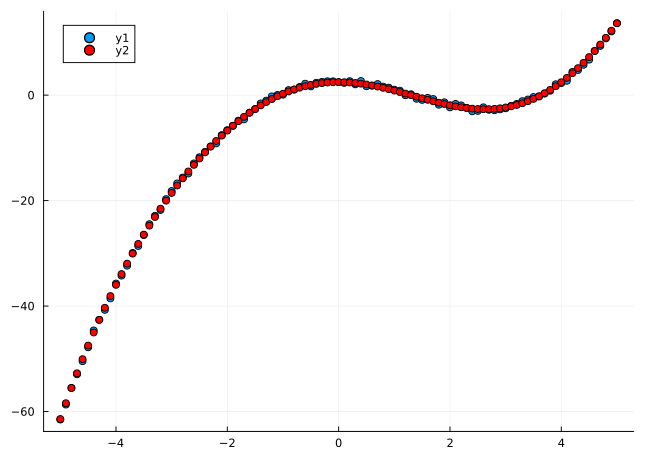

In [15]:
y_pred = predict(mach, X)
 
scatter(x, y);
scatter!(x, y_pred, color = "red")